### Start-up

Run this cell cell only befor the first execution, or after you made changes to ```cubes_e2e.py```. 

In [1]:
%run cubes_e2e_refresh.py

Uncomment this cell to enable plot interactivity.

In [2]:
#%matplotlib notebook

Uncomment this cell to perform memory checks.

In [3]:
#%load_ext memory_profiler

Specify a wavelength or a list of wavelengths (in nm) at which the value of the quantities is to be printed on the plots.

In [4]:
test_wave = 375.6482

### Input spectra

Select the spectral template for the science target: ```flat``` for a flat spectrum, ```PL``` for a power-law, or ```custom``` for a custom spectrum to be read from a file. If you select ```custom```, please provide the path to the file as well. Wavelengths in the file must be expressed in Angstrom.


**NB**: run this cell if you run the one at the top.

In [5]:
sim.spec_templ = 'custom'  # Template 
sim.spec_file = 'Science_Spectra/ABrefSp1877.dat'  # Path to file

Specify the minimum and maximum wavelength to cut the spectrum.

**NB**: the range should fall within the wavelength span of the template, but large enough to cover all the instrument's arm (see below).

In [6]:
sim.wmin = 299 * au.nm  # Minimum wavelength
sim.wmax = 410 * au.nm  # Maximum wavelength

Specify the ```AB``` or ```Vega``` magnitude of the target in a given photometric band. Available bands are Johnson ```U```, ```B```, and ```V```. The magnitude will be converted into a photon flux density in the band and use to rescale the spectral template.

**NB**: be sure that the band you choose is wholly covered by your spectral template.

In [7]:
sim.mag_syst = 'Vega'  # System
sim.mag_band = 'U'  # Band
sim.targ_mag = 18  # Magnitude

Only for extragalactic spectra: provide an emission redshift and chose how to model the IGM absorption (```simple``` for a simple integration of the Lyman-alpha curve of growth; ```inoue``` for the more accurate formulae from Inoue et al. 2014, covering all the Lyman series).

**NB**: Be sure that ```zem``` is set to ```None``` if you are **not** using an extragalactic spectrum.

In [8]:
sim.zem = None  # Emission redshift
sim.igm_abs = 'simple'  # IGM absorption

Adjust the atmospheric parameters and compute the spectrum of the sky background with SkyCalc. If any of these values is ```None```, a pre-computed background will be used (with ```airmass``` = 1.16, ```pwv``` = 2.5, ```moond``` = 0).

**NB**: SkyCalc execution may be time consuming.

In [9]:
sim.airmass = None  # Airmass
sim.pwv = None # Precipitable water vapor
sim.moond = None  # Days from new moon

Finally, plot the input spectra of target and background for a given exposure time. Optionally save the target spectrum in a format accepted by the CUBES ETC 

**NB**: to properly save the spectrum, ```sim.mag_syst``` and ```sim.mag_band``` above must be ```Vega``` and ```V```, respectively. ```sim.qso_zem``` must be above 1 to have enough flux in the Vega V band (and avoid normalization issues).

Photons collected.
Input spectra created.
Target magnitude: U_Vega: 18.000; V_Vega: 18.770.
Sky spectrum and atmospheric extinction imported from static model (airmass = 1.16, pwv = 30.0, moond = 0.0).
Background magnitude (per arcsec^2): U_Vega: 21.996; V_Vega: 22.397.


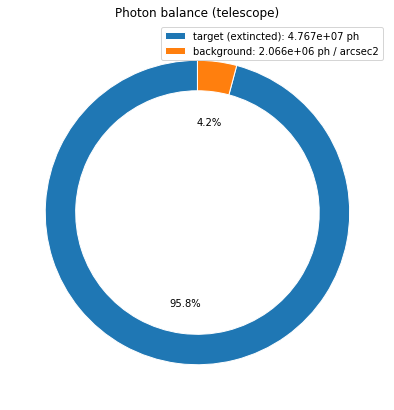

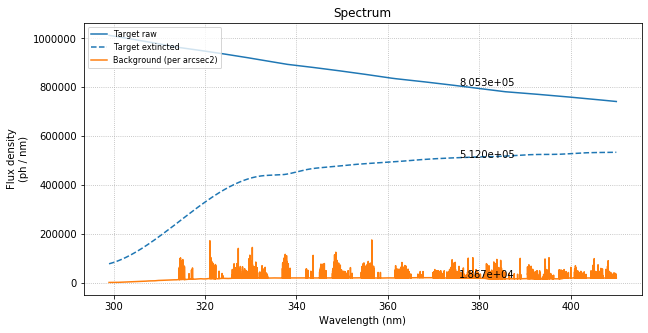

In [10]:
sim.texp = 3600*au.s  # Exposure time
sim.spec_in(test_wave)
#%mprun -f sim.spec_in sim.spec_in()  # Only for memory checks

### PSF and slices

Define a function for the PSF of the target in the sky (```tophat```  or ```gaussian```). The ```seeing``` parameters provides the radius of the ```tophat``` function or the FWHM of the ```gaussian``` function.

In [11]:
sim.psf_func = 'gaussian'  # Function to represent the PSF
sim.seeing = 0.87*au.arcsec  # Seeing

If the target is extended, choose a suitable profile (```invrad``` for inverse-radius profile, ```sersic``` for a Sersic profile) and tune its parameters. In the case of an extended target, the magnitude defines the number of photons within the effective radius ```r_eff```. The parameters for the Sersic profile are those defined for the [Astropy class ```Sersic2D```](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Sersic2D.html#astropy.modeling.functional_models.Sersic2D.evaluate).

In [12]:
sim.targ_prof = None
sim.targ_invrad_params = {'r_eff': 2}
sim.targ_sersic_params = {'amplitude': 1, 'r_eff': 2, 'n': 4, 'x_0': 0.5, 'y_0': 0.5, 'ellip': 0.5, 'theta': 1} 

Design the slices onto the PSF, specifying their number and size.

Slices designed on field.     


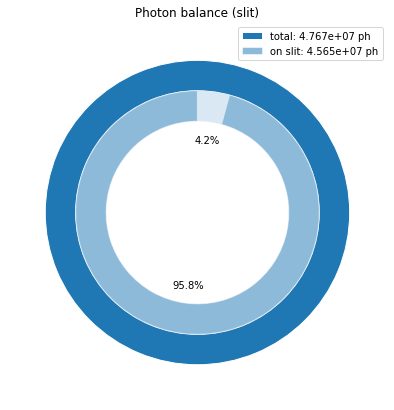

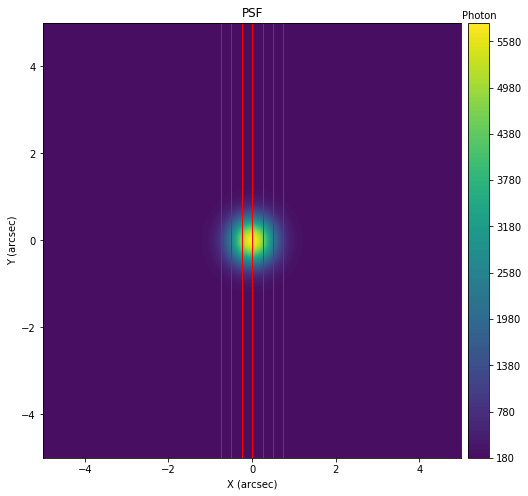

In [13]:
sim.slice_n = 6  # Number of slices
sim.slice_length = 10*au.arcsec  # Length of the slice
sim.slice_width = 0.25*au.arcsec  # Width of the slice
sim.psf()
#%mprun -f sim.psf sim.psf()  # Only for memory checks

### Spectral format

Specify the characteristics of the CCDs, including the size and binning of pixels. 

**NB**: The CCDs are assumed to be identical in all arms.

In [14]:
sim.ccd_gain = 1.1*au.photon/au.adu  # Gain (i.e. conversion from ADU to photons)
sim.ccd_ron = 2.5*au.photon / sim.ccd_gain  # Read-out noise (in ADU)
sim.ccd_dark = 0.5*au.photon/au.h / sim.ccd_gain  # Dark current (in ADU per unit time)
sim.ccd_xsize = 9*1024*au.pixel  # X size of the CCD 
sim.ccd_ysize = 9*1024*au.pixel  # Y size of the CCD
sim.pix_xsize = 10*au.micron  # X size of the pixels
sim.pix_ysize = 10*au.micron  # Y size of the pixels
sim.ccd_xbin = 1  # X binning of the CCD
sim.ccd_ybin = 1  # Y binning of the CCD

**NB**: The number of arms has been frozen and is 2 by default. If you want to experiment with a different number of arms, contact guido.cupani(at)inaf.it.

Efficiencies and dispersion are loaded from static files in directory ```database```. Efficiencies are loaded from  ```EFF_nARM_mCH``` (with ```n``` the number of arms and ```m``` the ordinal of each arm), while dispersion is loaded from file ```DISPERSION```. Edit those files only if needed. 

**NB**: The sampling in the dispersion file is the wavelength size of **non-binned** pixels. It will be converted internally to the wavelength size of binned pixels.

With ```sim.goal_eff``` you can switch between the typical-goal efficiencies (```True```; they are taken from the files with the ```_GOAL``` suffix in ```database```) or worst-case efficiencies (```False```).  

In [15]:
sim.goal_eff = True

Define the spatial scale.

In [16]:
sim.spat_scale = 0.3*au.arcsec/(30*au.micron)  # Spatial scale

Finally, set a value for the gap between the slices and display the spectral format.

**NB**: The sampling in the plot is that of **binned** pixels.

Slices projected onto arms.       


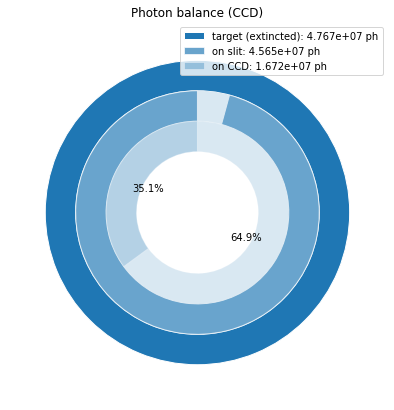

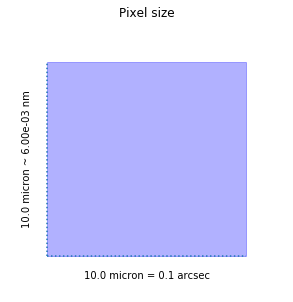

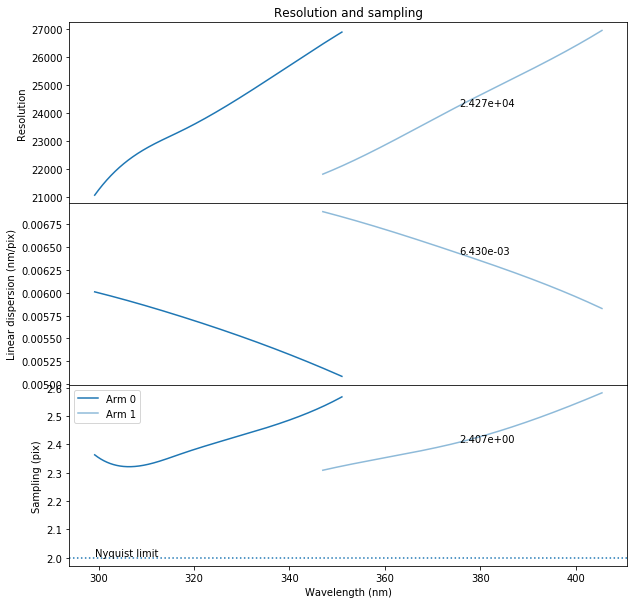

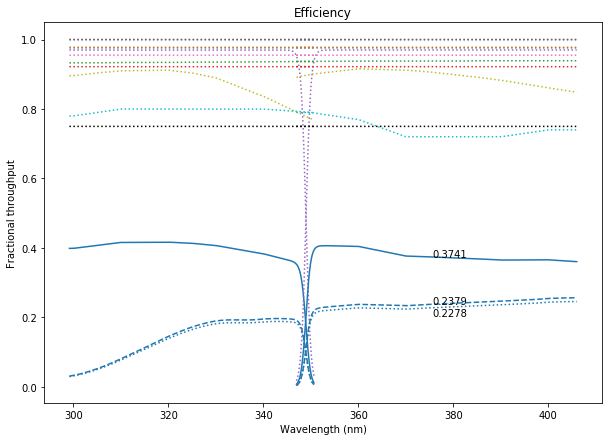

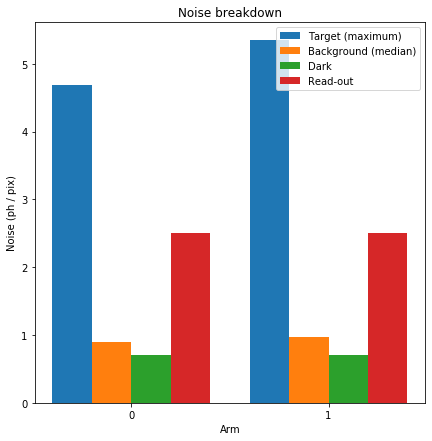

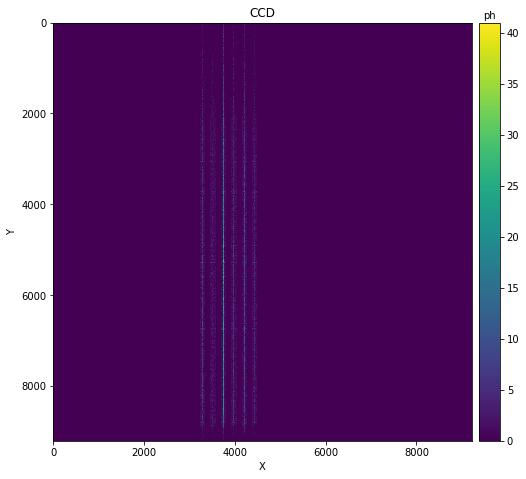

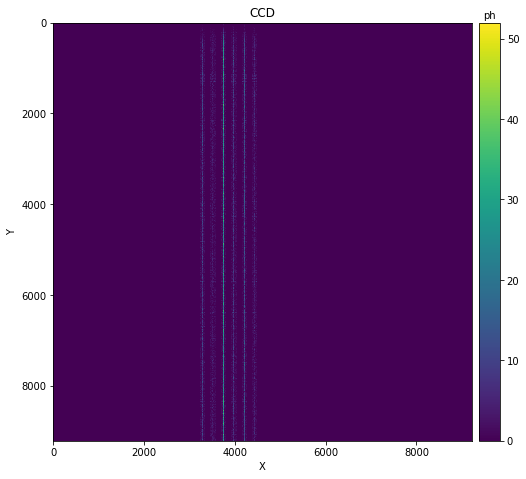

In [17]:
sim.slice_gap = 110*au.pixel  # Gap between the slices
sim.ccd(test_wave)
#%mprun -f sim.ccd sim.ccd()  # Only for memory checks

### Output spectrum

Select the extraction method: ```sum``` for a simple boxcar summation, ```opt``` for Horne-like optimal extraction. In case of ```sum```, you can also specify the number of FWHMs around the object traces over which extraction is carried out. 

NB: ```opt``` has not been thoroughly tested and is very time-consuming.

In [18]:
sim.extr_func = 'sum'  # Function for extracting the spectrum
sim.extr_fwhm_num = 1.2   # Number of FWHMs used in 'sum' extraction

Choose the sampling to compute the signal-to-noise ratio on the extracted spectrum.

In [19]:
sim.snr_sampl = 1*au.nm  # Data points per SNR point

Finally, extract the spectrum and display it:

SNR across arm 0:               
 300.00 nm:   6
 313.00 nm:  11
 317.33 nm:  17
 334.67 nm:  19
 352.01 nm:   0
SNR across arm 1:               
 346.29 nm:   0
 360.97 nm:  26
 375.65 nm:  23
 390.33 nm:  23
 405.00 nm:  23

Summary:

 - Atmosphere efficiency:             0.636
 - Slit efficiency:                   0.958
 - Instrument efficiency:             0.499
 - Telescope efficiency:              0.750
 - Total efficiency (for target):     0.228
 - Total efficiency (for background): 0.374

 - Exposure time:    3.600e+03 s
 - Telescope area:   4.87575e+05 cm2
 - Test wavelength:  3.756e+02 nm
 - Sampling (d-lam): 6.430e-03 nm / pix

 - Target flux:
    - density, raw       (OBJ F0):    4.588e-05 ph / (Angstrom cm2 s)
    - density, extincted (OBJ F1):    2.917e-05 ph / (Angstrom cm2 s)
    - density, on CCD    (OBJ F2):    1.045e-05 ph / (Angstrom cm2 s)
    - collected, on CCD  (OBJ F3):    1.834e+04 ph / Angstrom
    - integrated, on CCD (OBJ F4):    1.179e+03 ph / pix
    - ex

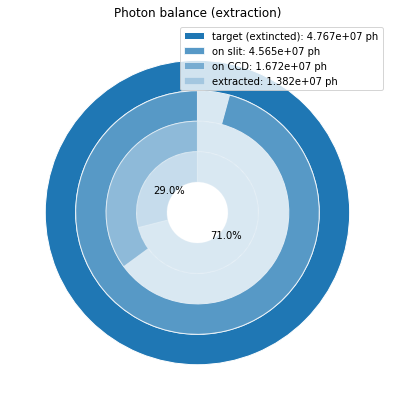

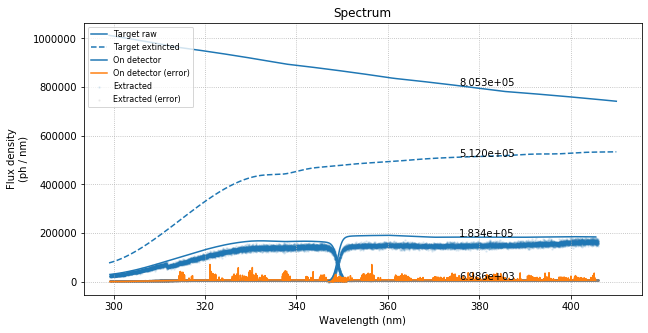

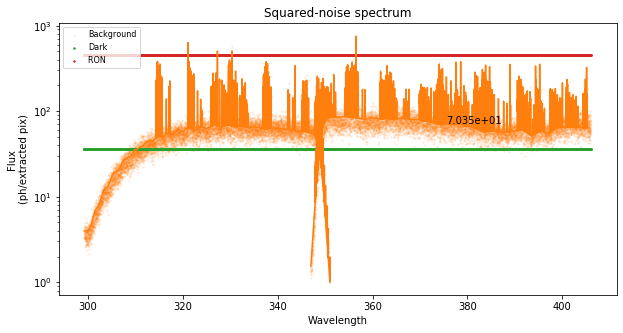

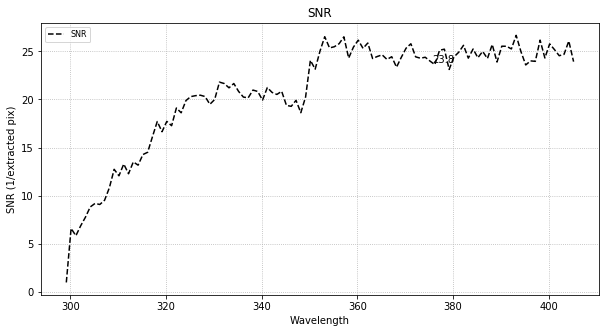

In [20]:
sim.spec_draw(test_wave)
#%mprun -f sim.spec_draw sim.spec_draw()  # Only for memory checks